# ML in Cybersecurity: Task II

## Team
  * **Team name**:  *fill this in*
  * **Members**:  *fill this in. format: name1 (email1), name2 (email2), ...*


## Logistics
  * **Due date**: 25th Nov. 2021, 23:59:59 (email the completed notebook including outputs to mlcysec_ws2022_staff@lists.cispa.saarland)
  * Email the completed notebook to mlcysec_ws2022_staff@lists.cispa.saarland 
  * Complete this in the previously established **teams of 3**
  * Feel free to use the course forum to discuss.
  
  
## About this Project
In this project, we dive into the vulnerabilities of machine learning models and the difficulties of defending against them. To this end, we ask you to implement an evasion attack (craft adversarial examples) yourselves, and defend your own model.   


## A Note on Grading
The total number of points in this project is 100. We further provide the number of points achievable with each excercise. You should take particular care to document and visualize your results.

Whenever possible, please use tools like tables or figures to compare the different findings


 
## Filling-in the Notebook
You'll be submitting this very notebook that is filled-in with (all) your code and analysis. Make sure you submit one that has been previously executed in-order. (So that results/graphs are already visible upon opening it). 

The notebook you submit **should compile** (or should be self-contained and sufficiently commented). Check tutorial 1 on how to set up the Python3 environment.

It is extremely important that you **do not** re-order the existing sections. Apart from that, the code blocks that you need to fill-in are given by:
```
#
#
# ------- Your Code -------
#
#
```
Feel free to break this into multiple-cells. It's even better if you interleave explanations and code-blocks so that the entire notebook forms a readable "story".


## Code of Honor
We encourage discussing ideas and concepts with other students to help you learn and better understand the course content. However, the work you submit and present **must be original** and demonstrate your effort in solving the presented problems. **We will not tolerate** blatantly using existing solutions (such as from the internet), improper collaboration (e.g., sharing code or experimental data between groups) and plagiarism. If the honor code is not met, no points will be awarded.

 
  ---

In [1]:
import time 
 
import numpy as np 
import matplotlib.pyplot as plt 

import json 
import time 
import pickle 
import sys 
import csv 
import os 
import os.path as osp 
import shutil 

import pandas as pd

from IPython.display import display, HTML
 
%matplotlib inline 
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots 
plt.rcParams['image.interpolation'] = 'nearest' 
plt.rcParams['image.cmap'] = 'gray' 
 
# for auto-reloading external modules 
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython 
%load_ext autoreload
%autoreload 2

In [2]:
# Some suggestions of our libraries that might be helpful for this project
from collections import Counter          # an even easier way to count
from multiprocessing import Pool         # for multiprocessing
from tqdm import tqdm                    # fancy progress bars

# Load other libraries here.
# Keep it minimal! We should be easily able to reproduce your code.
# We only support sklearn and pytorch.
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.utils.data as data

# We preload pytorch as an example
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset


In [3]:
log_interval = 10
random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)
rndm_state = 42

In [4]:
compute_mode = 'gpu'

if compute_mode == 'cpu':
    device = torch.device('cpu')
elif compute_mode == 'gpu':
    # If you are using pytorch on the GPU cluster, you have to manually specify which GPU device to use
    # It is extremely important that you *do not* spawn multi-GPU jobs.
    os.environ["CUDA_VISIBLE_DEVICES"] = '0'    # Set device ID here
    device = torch.device('cuda')
else:
    raise ValueError('Unrecognized compute mode')

print(device)

cuda


#### Helpers

In case you choose to have some methods you plan to reuse during the notebook, define them here. This will avoid clutter and keep rest of the notebook succinct.

In [ ]:
#
#
# ------- Your Code -------
#
#

# 1. Attacking an ML-model (30 points) 

In this section, we implement an attack ourselves. First, however, you need a model you can attack. Feel free to choose the DNN/ConvNN from task 1.



## 1.1: Setting up the model and data (4 Points)

Load the MNIST data, as done in task 1. 

Re-use the model from task 1 here and train it until it achieves reasonable accuracy (>92%).

If you have the saved checkpoint from task 1, you can load it directly. But please compute here the test accuracy using this checkpoint.  

**Hint:** In order to save computation time for the rest of exercise, you might consider having a relatively small model here.

**Hint**: You might want to save the trained model to save time later.

In [ ]:
#
#
# ------- Your Code -------
# Feel free to change this part depending on whether you would train a model or directly load a checkpoint 
#
#

# (1)load data 
# (2)define model
# (3)define loss, optimizer 
# (4)train (You can re-use the trained model from project1)
# (5)evaluate
print('Epoch %d, Train acc: %f, Test acc: %f' % (epoch, train_acc, test_acc))

In [5]:
# (1) Load test data
batch_size = 2000
root = './data'
if not os.path.exists(root):
    os.mkdir(root)
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])

#trans = transforms.Compose([transforms.ToTensor(), transforms.Compose([transforms.ToTensor()]) ])


# if not exist, download mnist dataset
test_dataset = torchvision.datasets.MNIST(root=root, train=False, transform=trans, download=True) #this
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


print(len(test_loader.dataset))

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

10000


In [6]:
# (2) Define Model

use_cuda=True

# LeNet Model definition
class Net(nn.Module):
    def __init__(self, input_size, hidden_layers, num_classes):
        super(Net, self).__init__()
        self.layers = []
        self.layers.append(nn.Conv2d(input_size,hidden_layers[0],5))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.MaxPool2d(stride = 1, kernel_size = 2))
        self.layers.append(nn.Dropout(0.5))
        self.layers.append(nn.Conv2d(hidden_layers[0],hidden_layers[1],5))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.MaxPool2d(kernel_size = 2, stride = 1))
        self.layers.append(nn.Dropout(0.5))
        #self.layers.append(nn.Linear(hidden_layers[1],num_classes))
        self.layers = nn.Sequential(*self.layers)
        #self.f = nn.flatten()
        self.fc = nn.Sequential(nn.Linear(46656,num_classes))
        # self.fc2 = nn.Sequential(nn.Softmax())
        self.fullnn = [self.layers,self.fc]

    def forward(self, x):
     
        x = self.layers(x)
        x = x.view(x.size(0), -1)
        out1 = (self.fc(x))
      
        return out1

In [7]:
# (4) Load model

pretrained_model ="/content/best_modelyes.ckpt"

# Define what device we are using
#print("CUDA Available: ",torch.cuda.is_available())
#device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

# Initialize the network
input_size =  1
hidden_layers = [20,144]
num_classes = 10
model = Net(input_size, hidden_layers, num_classes).to(device)

# Load the pretrained model
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

# Set the model in evaluation mode. In this case this is for the Dropout layers
model.eval()

Net(
  (layers): Sequential(
    (0): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.5, inplace=False)
    (4): Conv2d(20, 144, kernel_size=(5, 5), stride=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.5, inplace=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=46656, out_features=10, bias=True)
  )
)

In [8]:
def test_or(test_loader_nn,model):
   original = []
   original_img = []
   with torch.no_grad():
      correct = 0
      total = 0
      for i, (images, labels) in enumerate(test_loader_nn):
          
          images = images.to(device)
         
          labels = labels.to(device)
          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
          
          for j in range(len(images)):
            #print(predicted[j])
            original.append((labels[j].item(), predicted[j].item()))
            original_img.append(images[j].cpu().detach().numpy()  )
          
          # if total == 1000:
          #     break
      acc = 100 * correct / total
      print
      print('Accuracy of the network on the {} test images: {} %'.format(total, acc))
   return test_loader_nn,original, original_img, acc

In [9]:
# (5) Evaluate model


test_loader,original, or_image, test_acc = test_or(test_loader,model)


Accuracy of the network on the 10000 test images: 98.63 %


## 1.2: Implementing the FGSM attack (7 Points)

We now want to attack the model trained in the previous step. We will start with the FGSM attack as a simple example. 

Please implement the FGSM attack mentioned in the lecture. 

More details: https://arxiv.org/pdf/1412.6572.pdf


In [62]:
#
#
# ------- Your Code -------
#
#

# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1) #?????
    # Return the perturbed image
    return perturbed_image

## 1.3: Adversarial sample set (7 Points)

* Please generate a dataset containing at least 1,000 adversarial examples using FGSM.

* Please vary the perturbation budget (3 variants) and generate 1,000 adversarial examples for each. 
    * **Hint**: you can choose epsilons within, e.g., = [.05, .1, .15, .2, .25, .3],  using MNIST pixel values in the interval       [0, 1]

* Compute the accuracy of each attack set. 

In [63]:
def test( model, device, test_loader, epsilon, dataset_size):

    correct = 0
    wrong = 0
    adv_examples = []
    total = 0
    
    for i, (data, target) in enumerate(test_loader):

        data, target = data.to(device), target.to(device)
        data.requires_grad = True

        total += target.size(0)

        # Forward pass
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1]

        # Don't attack if the initial prediction is wrong
        for j in range(len(data)):
          if init_pred[j].item() != target[j].item():
            continue
     
        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()
       
        # FGSM Attack
        data_grad = data.grad.data
        #plt.plot(data.squeeze().detach().cpu().numpy()  )
        #plt.show()
        perturbed_data = fgsm_attack(data, epsilon, data_grad)
        
        output = model(perturbed_data)

        # New prediction
        final_pred = output.max(1, keepdim=True)[1]     
        
        for k in range(len(data)):
          if final_pred[k].item() == target[k].item():
            correct += 1
          else:
            wrong += 1
            if len(adv_examples) < dataset_size:
               adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
               adv_examples.append( (init_pred[k].item(), final_pred[k].item(), adv_ex[k]) )
    
    final_acc = 100*correct/total
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, total, final_acc))
   
    return final_acc, adv_examples


In [64]:
#
#
# ------- Your Code -------
#
#
import timeit

epsilons = [.05,.15, .3]
dataset_size= 20

accuracies = []
adv_samples = []

# Run test for each epsilon
for eps in epsilons:
    start = timeit.default_timer()
    acc, ex = test(model, device, test_loader, eps, dataset_size)
    stop = timeit.default_timer()
    print('Time: ', stop - start) 
    accuracies.append(acc)
    adv_samples.append(ex)



Epsilon: 0.05	Test Accuracy = 7525 / 10000 = 75.25
Time:  11.840313329999844
Epsilon: 0.15	Test Accuracy = 4571 / 10000 = 45.71
Time:  11.583235525999953
Epsilon: 0.3	Test Accuracy = 976 / 10000 = 9.76
Time:  11.570318932000191


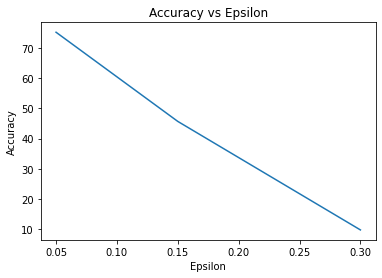

In [65]:
plt.plot(epsilons, accuracies)
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

## 1.4: Visualizing the results (7 Points)

* Please chose one sample for each class (for example the first when iterating the test data) and plot the (ten) adversarial examples as well as the predicted label (before and after the attack)

* Please repeat the visualization for the three sets you have created 

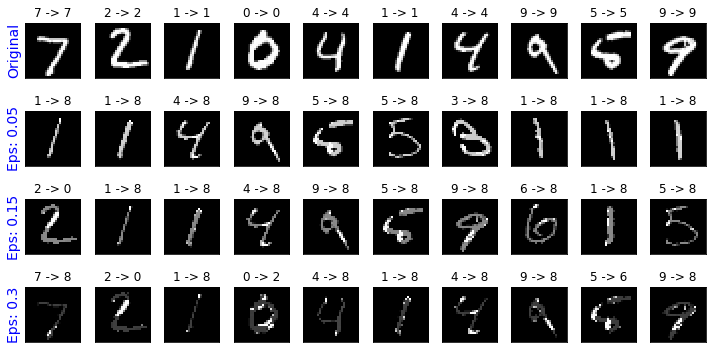

In [66]:
count = 0
nsamples = 10

plt.figure(figsize=(10,5))
for i in range(len(epsilons)+1):

    for j in range(nsamples):
        count += 1
        plt.subplot(len(epsilons)+1,nsamples,count)
        plt.xticks([], [])
        plt.yticks([], [])
        
        if i == 0:
          plt.imshow(or_image[j].squeeze(), cmap="gray")
          plt.title("{} -> {}".format(original[j][0], original[j][1]))
          if j == 0:
             plt.ylabel("Original", fontsize=14, color = 'b')

        else:
          orig,adv,ex = adv_samples[i-1][j]
          plt.title("{} -> {}".format(orig, adv))
          plt.imshow(ex, cmap="gray")
          if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i-1]), fontsize=14, color = 'b')
        
plt.tight_layout()
plt.show()

In [ ]:
#
#
# ------- Your Code -------
#
#

# template code (Please feel free to change this)
# (each column corresponds to one attack method)
col_titles = ['Ori','FGSM','Method 1', 'Method 2'] 

nsamples = 10
nrows = nsamples
ncols = len(col_titles)

fig, axes = plt.subplots(nrows,ncols,figsize=(8,12))  # create the figure with subplots
[ax.set_axis_off() for ax in axes.ravel()]  # remove the axis

for ax, col in zip(axes[0], col_titles): # set up the title for each column
    ax.set_title(col,fontdict={'fontsize':18,'color':'b'})

for i in range(nsamples):
   
    axes[i,0].imshow(images_ori[i])
    axes[i,1].imshow(adv_FGSM[i])
    axes[i,2].imshow(adv_Method1[i])
    axes[i,3].imshow(adv_Method2[i])

plt.tight_layout()
plt.show()               

## 1.5: Analyzing the results (5 Points)

Please write a brief summary of your findings.  

* Does the attack always succeed (the model makes wrong prediction on the adversarial sample)? What is the relationship between the attack success rate and the perturbation budget?
* How about the computation cost of the attack? (you can report the time in second) 
* Does the attack require white-box access to the model?
* Feel free to report your results via tables or figures, and mention any other interesting observations 



**Your answers go here**

# 2. Defending an ML model (35 points) 

So far, we have focused on attacking an ML model. In this section, we want you to defend your model. 


## 2.1: Implementing the adversarial training defense (20 Points)

* We would like to ask you to implement the adversarial training defense (https://arxiv.org/pdf/1412.6572.pdf) mentioned in the lecture. 

* You can use the **FGSM adversarial training** method (i.e., train on FGSM examples). 

* You can also check the adversarial training implementation in other papers, e.g., http://proceedings.mlr.press/v97/pang19a/pang19a.pdf 

* Choose a certain **maximum perturbation budget** during training that is in the middle of the range you have experimented with before. 

* We do not require the defense to work perfectly - but what we want you to understand is why it works or why it does not work.

**Hint:** You can save the checkpoint of the defended model as we would need it to for the third part of this exercise.


In [ ]:
#
#
# ------- Your Code -------
#
#


In [ ]:
def advTrain(torch_model, train_loader, test_loader,
        nb_epochs=NB_EPOCHS, batch_size=BATCH_SIZE, train_end=-1, test_end=-1, learning_rate=LEARNING_RATE):
    optimizer = optim.Adam(torch_model.parameters(), lr=learning_rate)
    train_loss = []
    total = 0
    correct = 0
    totalAdv = 0
    correctAdv = 0
    step = 0
    # breakstep = 0
    for _epoch in range(nb_epochs):
      for xs, ys in train_loader:
        #Normal Training
        xs, ys = Variable(xs), Variable(ys)
        if torch.cuda.is_available():
          xs, ys = xs.cuda(), ys.cuda()
        optimizer.zero_grad()
        preds = torch_model(xs)
        loss = F.nll_loss(preds, ys)
        loss.backward()  # calc gradients
        train_loss.append(loss.data.item())
        optimizer.step()  # update gradients
        preds_np = preds.cpu().detach().numpy()
        correct += (np.argmax(preds_np, axis=1) == ys.cpu().detach().numpy()).sum()
        total += train_loader.batch_size

        #Adversarial Training
        xs = fast_gradient_method(torch_model, xs, eps=0.3, norm=np.inf, clip_min=0., clip_max=1.)
        xs, ys = Variable(xs), Variable(ys)
        if torch.cuda.is_available():
            xs, ys = xs.cuda(), ys.cuda()
        optimizer.zero_grad()
        preds = torch_model(xs)
        loss = F.nll_loss(preds, ys)
        loss.backward()  # calc gradients
        train_loss.append(loss.data.item())
        optimizer.step()  # update gradients
        preds_np = preds.cpu().detach().numpy()
        correctAdv += (np.argmax(preds_np, axis=1) == ys.cpu().detach().numpy()).sum()
        totalAdv += train_loader.batch_size
        
        step += 1
        if total % 1000 == 0:
          acc = float(correct) / total
          print('[%s] Clean Training accuracy: %.2f%%' % (step, acc * 100))
          total = 0
          correct = 0
          accAdv = float(correctAdv) / totalAdv
          print('[%s] Adv Training accuracy: %.2f%%' % (step, accAdv * 100))
          totalAdv = 0
          correctAdv = 0

NameError: ignored

In [ ]:
def train_model(dropout_s,model,learning_rate,reg,train_loader_nn,val_loader_nn,best_accuracy,num_epochs,total_train,correct_train,train_acc,val_accu_data,val_accu,learning_rate_decay,train_accu,loss_values):
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=reg)
    lr = learning_rate
    total_step = len(train_loader_nn)
    # print(total_step)
    for epoch in range(num_epochs):

        for i, (images, labels) in enumerate(train_loader_nn):

           images = images.to(device)
           labels = labels.to(device)

        # Forward pass
           outputs = model(images)

           loss = criterion(outputs, labels)
          #  print(i)
        # Backward and optimize
           optimizer.zero_grad()
           loss.backward()
           optimizer.step()
        
           loss_ar.append(loss.item())
           if (i+1) % 25 == 0:
              print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, total_step, loss.item()))
              _, predicted_train = torch.max(outputs.data, 1)
              loss_values.append(loss.item())
              total_train += labels.size(0)
              correct_train += (predicted_train == labels).sum().item() 
              # print(total_train,correct_train) 

        train_accu.append(100 * correct_train / total_train)
        correct_train = 0
        total_train = 0
    # Code to update the lr
        lr *= learning_rate_decay
        update_lr(optimizer, lr)
        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            for images, labels in val_loader_nn:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                #############
            print('Validataion accuracy is: {} %'.format(100 * correct / total))
            val_accu_data = (100 * correct) / total
            print(type(val_accu))
            val_accu.append(val_accu_data)
            # if val_accu_data < last:
            #     count+= 1
            # else:
            #     count = 0
            # last = val_accu_data
            # cur_accuracy = val_accu_data
            # if val_accu_data > best_accuracy:
            #     best_accuracy = val_accu_data
            #     best_model = model
            #     print("best")
            #     torch.save(best_model.state_dict(),'./best_model.ckpt')
    

        model.train()
    if(val_accu[num_epochs-1]> best_accuracy):
        best_accuracy = val_accu[num_epochs-1]
        torch.save(model.state_dict(),'./best_model'+str(dropout_s)+'.ckpt')                         
        print("best model with val acc"+ str(val_accu[num_epochs-1])+ "is saved")
    return   val_accu,val_accu[num_epochs-1],train_accu,best_accuracy,loss_values

## 2.2: Evaluation (10 Points)

* Craft adversarial examples using the **defended** model. This entails at least 1,000 examples crafted via FGSM. 
    * Create one set using a budget that is **less than (within)** the one used in training.
    * Create another set using a budget that is **higher than** the one used in training. 
    * You can use two values of epsilons from question 1.3 
    
* Evaluate the **defended** model on these two adversarial examples sets. 


In [ ]:
#
#
# ------- Your Code -------
#
#

print('Accuracy on the lower-budget adversarial samples (FGSM) %.2f'%acc_FGSM1)
print('Accuracy on the lower-budget adversarial samples (FGSM) after defense %.2f'%acc_FGSM_defend1)

print('Accuracy on the higher-budget adversarial samples (FGSM) %.2f'%acc_FGSM2)
print('Accuracy on the higher-budget adversarial samples (FGSM) after defense %.2f'%acc_FGSM_defend2)

## 2.3 Discussion (5 points)

* How successful was the defense against the attack compared to the undefended model? How do you interpret the difference?
* How did the two sets differ?

**Your answers go here**

# 3: I-FGSM attack (35 points) 

* FGSM is one of the simplest and earliest attacks. Since then, many more advanced attacks have been proposed. 
* One of them is the Iterative-FGSM (https://arxiv.org/pdf/1607.02533.pdf), where the attack is repeated multiple times.
* In this part, we ask you to please implement the iterative FGSM attack. 



## 3.1: Implementing the I-FGSM attack (10 Points)

**Hints**: 

* Your code should have an attack loop. At each step, the FGSM attack that you have implemented before is computed using a small step.
* After each step, you should perform a per-pixel clipping to make sure the image is in the allowed range, and that the perturbation is within budget.


In [ ]:
#
#
# ------- Your Code -------
#
#


In [59]:
# Also known as I-FGSM Attack
def basic_iterative_attack(model, images, labels, scale, eps, alpha, iters, data_grad) :
    #images = images.to(device)
    #labels = labels.to(device)
    
    clamp_max = 255

    
    if iters == 0 :
        # The paper said min(eps + 4, 1.25*eps) is used as iterations
        iters = int(min(eps + 4, 1.25*eps))
        print("Iters: ", iters)
                
    if scale :
        clamp_max = clamp_max / 255
        
    for i in range(iters) :    
        #images.requires_grad = True
        #outputs = model(images)

        #model.zero_grad()
        #cost = F.cross_entropy(outputs, labels).to(device)
        #cost.backward()
        sign_data_grad = data_grad.sign()
        attack_images = images + alpha*sign_data_grad
        
        # Clip attack images(X')
        # min{255, X+eps, max{0, X-eps, X'}}
        # = min{255, min{X+eps, max{max{0, X-eps}, X'}}}
        
        # a = max{0, X-eps}
        a = torch.clamp(images - eps, min=0)
        # b = max{a, X'}
        b = (attack_images>=a).float()*attack_images + (a>attack_images).float()*a
        # c = min{X+eps, b}
        c = (b > images+eps).float()*(images+eps) + (images+eps >= b).float()*b
        # d = min{255, c}
        
        images = torch.clamp(c, max=clamp_max).detach_()
        
            
    return images

In [39]:
def test_i( model, device, test_loader, epsilon, scale, alpha, iters):

    correct = 0
    wrong = 0
    adv_examples = []
    total = 0
    
    for i, (data, target) in enumerate(test_loader):

        data, target = data.to(device), target.to(device)
        data.requires_grad = True

        total += target.size(0)

        # Forward pass
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1]

        # Don't attack if the initial prediction is wrong
        for j in range(len(data)):
          if init_pred[j].item() != target[j].item():
            continue
     
        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()
       
        # FGSM Attack
        data_grad = data.grad.data
        #perturbed_data = fgsm_attack(data, epsilon, data_grad)
        perturbed_data = basic_iterative_attack(model, data, target, scale, epsilon, alpha, iters, data_grad)

        output = model(perturbed_data)

        # New prediction
        final_pred = output.max(1, keepdim=True)[1]     
        
        for k in range(len(data)):
          if final_pred[k].item() == target[k].item():
            correct += 1
          else:
            wrong += 1
            
            if len(adv_examples) < dataset_size:
               adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
               adv_examples.append( (init_pred[k].item(), final_pred[k].item(), adv_ex[k]) )
    
    print("WRONG: ", wrong)
    final_acc = 100*correct/total
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, total, final_acc))
   
    return final_acc, adv_examples


In [60]:
correct = 0
total = 0

alpha = 1
iters = 3

# scale =
# 0 : the images are scaled to [0, 255]
# 1 : the images are scaled to [0, 1]
scale = 1
import timeit

epsilons = [.05,.15, .3]
dataset_size= 20

i_accuracies = []
i_adv_samples = []

# Run test for each epsilon
for eps in epsilons:
    start = timeit.default_timer()
    #i_acc, i_ex = test_i(model, device, test_loader, eps, dataset_size)
    i_acc, i_ex = test_i(model, device, test_loader, eps, scale, alpha, iters)
    stop = timeit.default_timer()
    print('Time: ', stop - start) 
    i_accuracies.append(i_acc)
    i_adv_samples.append(i_ex)

WRONG:  829
Epsilon: 0.05	Test Accuracy = 9171 / 10000 = 91.71
Time:  11.789338874999885
WRONG:  9511
Epsilon: 0.15	Test Accuracy = 489 / 10000 = 4.89
Time:  11.639707358999658
WRONG:  9167
Epsilon: 0.3	Test Accuracy = 833 / 10000 = 8.33
Time:  11.722484091999831


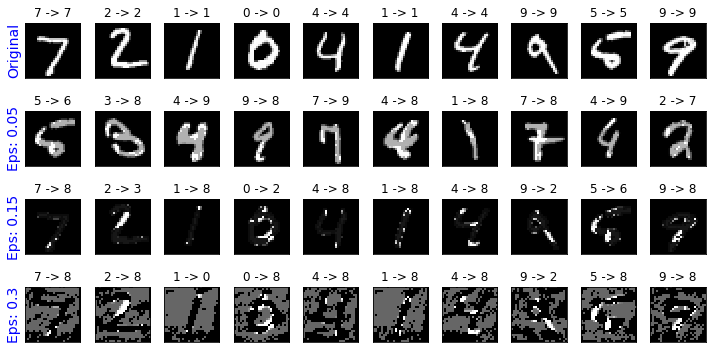

In [61]:
count = 0
nsamples = 10

plt.figure(figsize=(10,5))
for i in range(len(epsilons)+1):

    for j in range(nsamples):
        count += 1
        plt.subplot(len(epsilons)+1,nsamples,count)
        plt.xticks([], [])
        plt.yticks([], [])
        
        if i == 0:
          plt.imshow(or_image[j].squeeze(), cmap="gray")
          plt.title("{} -> {}".format(original[j][0], original[j][1]))
          if j == 0:
             plt.ylabel("Original", fontsize=14, color = 'b')

        else:
          orig,adv,ex = i_adv_samples[i-1][j]
          plt.title("{} -> {}".format(orig, adv))
          plt.imshow(ex, cmap="gray")
          if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i-1]), fontsize=14, color = 'b')
        
plt.tight_layout()
plt.show()

## 3.2: Attack the undefended model (5 Points)

* We will first attack the **undefended model** (i.e., without adversarial training).

* Choose one perturbation budget from Question **1.3** for comparison. 

    * Hint: A simple way to choose the small step is to divide the total budget by the number of steps (e.g., 10).

* Please generate 1000 adversarial examples using the **undefended** model and the **I-FGSM** you implemented. 

* Please compute the accuracy of the adversarial set on the **undefended** model. 

In [ ]:
#
#
# ------- Your Code -------
#
#


### 3.2.1: Findings and comparison with FGSM (8 points)

* Please report your findings. How successful was the attack? 

* What do you expect when increasing the number of steps? (you can experiment with different parameters of the attack and report your findings) 

* Compare with the basic FGSM. Using the same perturbation budget and using the same model, which attack is more successful? Why do you think this is the case? What about the computation time?

* Feel free to report any interesting observations. 

**Your answers go here**

## 3.3: Attack the defended model (5 poinst) 

* In the previous question, we attacked the **undefended model**. 

* Now, we want to explore how successful the previous implemented defense (FGSM adversarial training) is againts this new attack. (we will not implement a new defense here, we will be reusing your previous checkpoint of the **defended model**)


* Use the **defended model** to create one set of adversarial examples. Use a perturbation budget from Question **2.2** for comparison.  

In [ ]:
#
#
# ------- Your Code -------
#
#

### 3.3.1: Discussion (7 points) 
* Please report your results. How successful was the attack on the defended model? 
* Compare it with the success of the FGSM attack on the defended model. What do you observe? How do you interpret the difference? 
* How do you think you can improve the defense against I-FGSM attack?


* Feel free to state any interesting findings you encountered during this project.

**Your answers go here**